In [1]:
# If gspx is not installed, we add it to the path
import os, sys
gdir = os.path.dirname(os.getcwd())  # parent folder
sys.path.insert(0, gdir)

In [2]:
import numpy as np

from gspx.utils.display import plot_graph
from gspx.datasets import WeatherGraphData, uk_weather
from gspx.signals import QuaternionSignal
from gspx.qgsp import create_quaternion_weights, QGFT, QMatrix

In [3]:
uk_data = WeatherGraphData()
Ar, coords = uk_data.graph
s = uk_data.signal

In [4]:
df = uk_weather()

Aq = create_quaternion_weights(
    Ar, df, icols=['humidity'], jcols=['temp'],
    kcols=['wind_speed'])

100%|██████████| 2014/2014 [00:03<00:00, 530.29it/s]


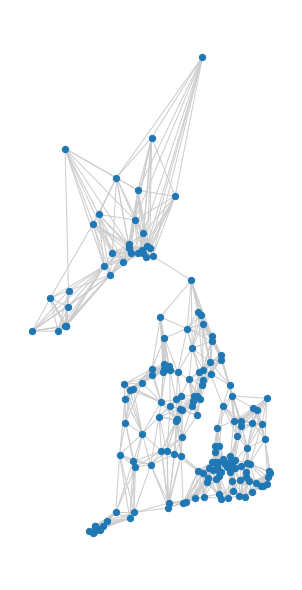

In [5]:
plot_graph(
    Aq.abs(), coords=coords,
    figsize=(4, 8), colormap='viridis',
    node_size=40)

In [6]:
qgft = QGFT()
qgft.fit(Aq)

Running eigendecomposition of the shift operator.
Sorting the frequencies based on Total Variation.


## Creating a quaternionic heat kernel

In [7]:
# Heat kernel in all 4 quaternion dimensions
k = 0.2
ss = np.exp(-k * np.arange(len(qgft.idx_freq)))

ss = QuaternionSignal.from_rectangular(
    np.hstack([ss[:, np.newaxis]] * 4)
)

In [8]:
rnd = np.random.RandomState(seed=42)
err_amplitude = 0.15

nn = QuaternionSignal.from_equal_dimensions(
    rnd.uniform(low=-err_amplitude, high=err_amplitude, size=len(ss))
)

findfont: Font family ['palatino'] not found. Falling back to DejaVu Sans.
findfont: Font family ['palatino'] not found. Falling back to DejaVu Sans.


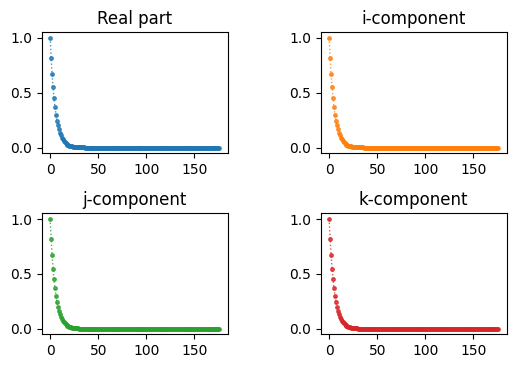

In [9]:
QuaternionSignal.show(ss)

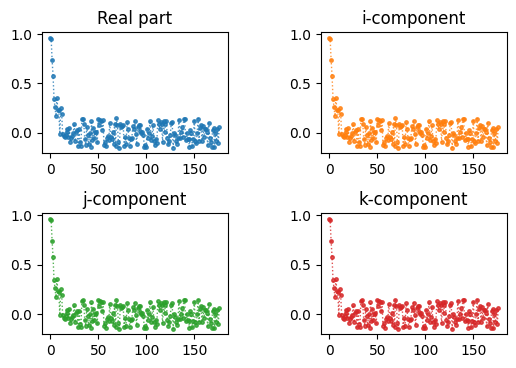

In [10]:
QuaternionSignal.show(ss + nn)

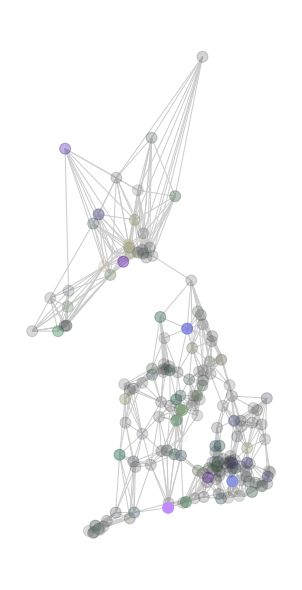

In [11]:
s = qgft.inverse_transform(ss)

obj = QuaternionSignal.from_samples(s.matrix.ravel())
node_color = [tuple(rgba) for rgba in obj.to_rgba()]

plot_graph(
    Aq.abs(), coords=coords, colors=node_color,
    figsize=(4, 8), colormap='viridis',
    node_size=120)

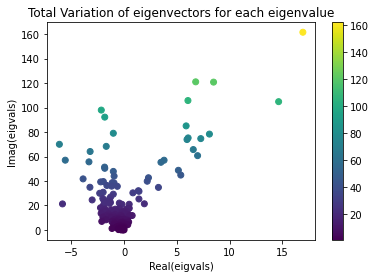

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(np.real(qgft.eigc), np.imag(qgft.eigc), c=qgft.tv_)
plt.colorbar()
plt.title("Total Variation of eigenvectors for each eigenvalue")
plt.xlabel("Real(eigvals)")
plt.ylabel("Imag(eigvals)")
plt.show()

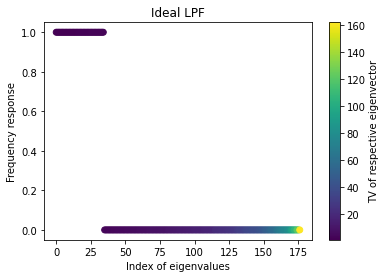

In [13]:
idx_freq = qgft.idx_freq

h_ideal = np.zeros(len(idx_freq))

# Bandwith of 20% the frequency support
bandwidth = int(len(idx_freq) / 5)
h_ideal[idx_freq[:bandwidth]] = 1

plt.figure()
plt.scatter(np.arange(len(idx_freq)), h_ideal[idx_freq], c=qgft.tv_[idx_freq])
plt.xlabel("Index of eigenvalues")
plt.ylabel("Frequency response")

cbar = plt.colorbar()
cbar.set_label("TV of respective eigenvector", rotation=90)
plt.title("Ideal LPF")
plt.show()

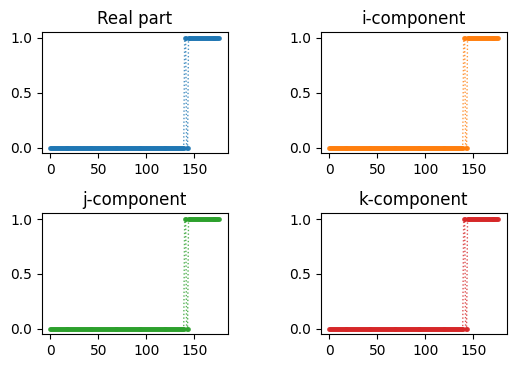

In [14]:
h_idealq = QuaternionSignal.from_rectangular(np.hstack((
    h_ideal[:, np.newaxis],
    h_ideal[:, np.newaxis],
    h_ideal[:, np.newaxis],
    h_ideal[:, np.newaxis]
)))
QuaternionSignal.show(h_idealq)

In [15]:
from gspx.qgsp import QMatrix
deg = 7

X = QMatrix.vander(qgft.eigq, deg, increasing=True)
y = h_idealq
print(X.shape, y.shape)

(177, 7) (177, 1)


LR: 0.38: 100%|██████████| 500/500 [02:12<00:00,  3.77it/s]


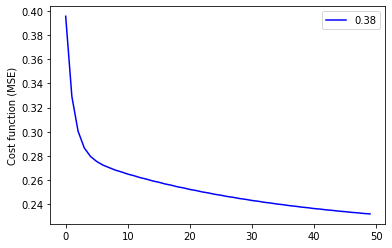

In [16]:
from gspx.adaptive import QLMS

qlms = QLMS(alpha=[0.38], max_iter=500)
qlms.fit(X, y)
qlms.plot()

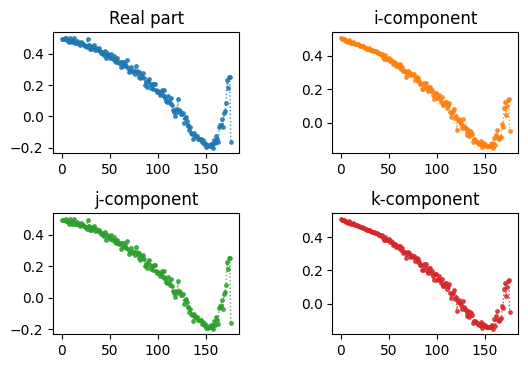

In [17]:
h_opt = qlms.predict(X)
h_opt = QuaternionSignal.from_samples(h_opt.matrix.ravel())
h_opt_ordered = QuaternionSignal.from_samples(h_opt.matrix.ravel()[idx_freq])
QuaternionSignal.show(h_opt_ordered)

In [18]:
sn = qgft.inverse_transform(ss + nn)

In [19]:
print("MSE prior:", np.mean((s - sn).abs()**2))

MSE prior: 0.030558598794577223


In [22]:
ssn_lpf = (ss + nn).hadamard(h_opt)
s_lpf = qgft.inverse_transform(ssn_lpf)

print("MSE post:", np.mean((s - s_lpf).abs()**2))

MSE post: 0.07367120917877774


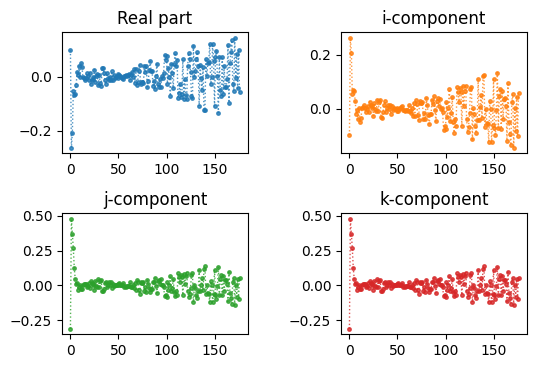

In [23]:
QuaternionSignal.show(ssn_lpf)